In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('Network_anomaly_data.csv')
df['is_attack'] = df['attack'].apply(lambda x: 'normal' if x=='normal' else 'attack')
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,is_attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,attack
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal


In [4]:
df.shape

(125973, 44)

In [5]:
df['srvserrorrate'].value_counts()

,count
srvserrorrate,
0.00,88754
1.00,34874
0.50,432
0.33,273
0.25,233
...,...
0.57,1
0.74,1
0.65,1


In [6]:
df['srvserrorrate'].nunique()

86

<Axes: xlabel='srvserrorrate', ylabel='Density'>

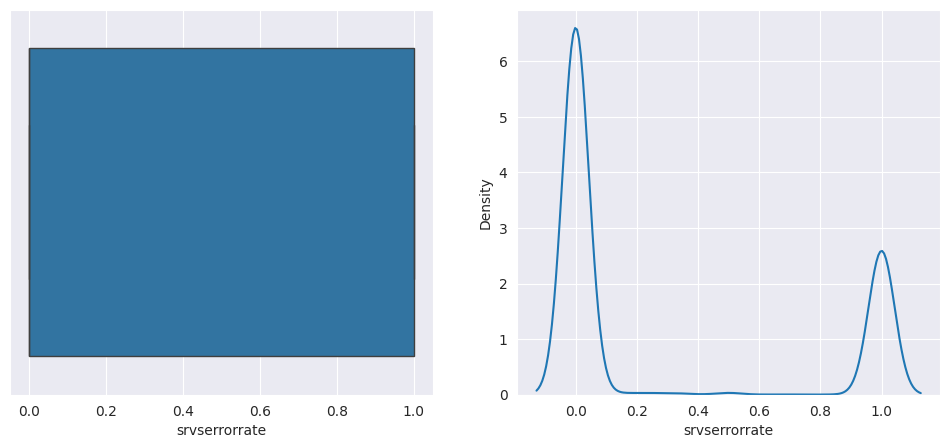

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='srvserrorrate')
plt.subplot(1,2,2)
sns.kdeplot(data=df,x='srvserrorrate')

In [8]:
pd.DataFrame(df['srvserrorrate'].describe()).T

,count,mean,std,min,25%,50%,75%,max
srvserrorrate,125973.0,0.282485,0.447022,0.0,0.0,0.0,1.0,1.0


In [9]:
np.percentile(df['srvserrorrate'],75),np.percentile(df['srvserrorrate'],50),np.percentile(df['srvserrorrate'],25)

(1.0, 0.0, 0.0)

In [10]:
IQR = np.percentile(df['srvserrorrate'],75)-np.percentile(df['srvserrorrate'],25)
ulimit = np.percentile(df['srvserrorrate'],75) + 1.5*IQR
ulimit

2.5

In [11]:
not_outlier = df[df['srvserrorrate'] <= ulimit]
is_outlier = df[df['srvserrorrate'] > ulimit]
total_data = df.shape[0]
(not_outlier.shape[0]/total_data)*100, (is_outlier.shape[0]/total_data)*100

(100.0, 0.0)

In [12]:
# checking attacks above 50% error
df[df['srvserrorrate']>=0.5]['is_attack'].value_counts()

,count
is_attack,
attack,34836
normal,728


In [13]:
# checking attacks below 50% error
df[df['srvserrorrate']<0.5]['is_attack'].value_counts()

,count
is_attack,
normal,66615
attack,23794


In [14]:
srverdf = df.copy()
srverdf['login_failed'] = srverdf['numfailedlogins'].apply(lambda x: 0 if x == 0 else 1)
srverdf['is_hot'] = srverdf['hot'].apply(lambda x: 1 if x > 0 else 0)
srverdf['is_compromised'] = srverdf['numcompromised'].apply(lambda x: 1 if x > 0 else 0)
srverdf['nroot'] = srverdf['numroot'].apply(lambda x: 1 if x > 0 else 0)
srverdf['fc'] = srverdf['numfilecreations'].apply(lambda x: 1 if x > 0 else 0)
srverdf['attk'] = srverdf['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [15]:
# divide data into 4 bins each bin having 0.25%
srverdf['bins'] = None
for i in range(len(srverdf)):
  ser = srverdf.loc[i,'srvserrorrate']
  if ser < 0.25:
    srverdf.loc[i,'bins'] = 1
  elif ser >= 0.25 and ser < 0.5:
    srverdf.loc[i,'bins'] = 2
  elif ser >= 0.5 and ser < 0.75:
    srverdf.loc[i,'bins'] = 3
  else:
    srverdf.loc[i,'bins'] = 4

In [16]:
srverdf['bins'].value_counts()

,count
bins,
1,89819
4,35046
2,590
3,518


In [17]:
# number of attacks in each bin
pd.pivot_table(data=srverdf,index='bins',columns='is_attack',values='attk',aggfunc='count',margins=True)

is_attack,attack,normal,All
bins,,,
1,23762,66057,89819
2,32,558,590
3,147,371,518
4,34689,357,35046
All,58630,67343,125973


In [18]:
pd.pivot_table(data=srverdf,index='bins',columns='is_attack',values='attk',aggfunc='sum')

is_attack,attack,normal
bins,,
1,23762,0
2,32,0
3,147,0
4,34689,0


In [19]:
# type of attack in each bin : bin 1
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(1,ascending=False)

bins,1,2,3,4
attack,,,,
neptune,6898.0,27.0,43.0,34246.0
ipsweep,3599.0,NaN,NaN,NaN
satan,3535.0,NaN,NaN,98.0
portsweep,2787.0,NaN,90.0,54.0
smurf,2646.0,NaN,NaN,NaN
nmap,1228.0,NaN,NaN,265.0
back,944.0,5.0,7.0,NaN
teardrop,892.0,NaN,NaN,NaN
warezclient,887.0,NaN,1.0,2.0


In [20]:
# type of attack in each bin : bin 2
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(2,ascending=False).head(3)

bins,1,2,3,4
attack,,,,
neptune,6898.0,27.0,43.0,34246.0
back,944.0,5.0,7.0,NaN
buffer_overflow,30.0,NaN,NaN,NaN


In [21]:
# type of attack in each bin : bin 3
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(3,ascending=False).head(8)

bins,1,2,3,4
attack,,,,
portsweep,2787.0,NaN,90.0,54.0
neptune,6898.0,27.0,43.0,34246.0
back,944.0,5.0,7.0,NaN
imap,2.0,NaN,4.0,5.0
guess_passwd,50.0,NaN,2.0,1.0
warezclient,887.0,NaN,1.0,2.0
buffer_overflow,30.0,NaN,NaN,NaN
ftp_write,8.0,NaN,NaN,NaN


In [22]:
# type of attack in each bin : bin 4
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(4,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
neptune,6898.0,27.0,43.0,34246.0
nmap,1228.0,NaN,NaN,265.0
satan,3535.0,NaN,NaN,98.0
portsweep,2787.0,NaN,90.0,54.0
land,NaN,NaN,NaN,18.0
imap,2.0,NaN,4.0,5.0
warezclient,887.0,NaN,1.0,2.0
guess_passwd,50.0,NaN,2.0,1.0
back,944.0,5.0,7.0,NaN


In [23]:
# type of service in each bin : bin 1
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='service',columns='bins',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

bins,1,2,3,4
service,,,,
private,7786.0,NaN,69.0,13016.0
eco_i,4089.0,NaN,NaN,NaN
ecr_i,2887.0,NaN,NaN,NaN
other,1644.0,NaN,NaN,111.0
http,1162.0,30.0,37.0,1060.0
ftp_data,741.0,NaN,4.0,1131.0
ftp,442.0,NaN,1.0,393.0
telnet,195.0,NaN,3.0,1238.0
Z39_50,186.0,NaN,NaN,676.0


In [24]:
# type of service in each bin : bin 2
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='service',columns='bins',values='attk',aggfunc='count').sort_values(2,ascending=False).head(5)

bins,1,2,3,4
service,,,,
http,1162.0,30.0,37.0,1060.0
smtp,80.0,2.0,11.0,191.0
IRC,1.0,NaN,NaN,NaN
X11,4.0,NaN,NaN,2.0
Z39_50,186.0,NaN,NaN,676.0


In [25]:
# type of service in each bin : bin 3
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='service',columns='bins',values='attk',aggfunc='count').sort_values(3,ascending=False).head(10)

bins,1,2,3,4
service,,,,
private,7786.0,NaN,69.0,13016.0
http,1162.0,30.0,37.0,1060.0
smtp,80.0,2.0,11.0,191.0
finger,117.0,NaN,4.0,1101.0
ftp_data,741.0,NaN,4.0,1131.0
imap4,142.0,NaN,4.0,498.0
telnet,195.0,NaN,3.0,1238.0
ctf,133.0,NaN,1.0,429.0
netstat,58.0,NaN,1.0,301.0


In [26]:
# type of service in each bin : bin 4
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='service',columns='bins',values='attk',aggfunc='count').sort_values(4,ascending=False).head(10)

bins,1,2,3,4
service,,,,
private,7786.0,NaN,69.0,13016.0
telnet,195.0,NaN,3.0,1238.0
ftp_data,741.0,NaN,4.0,1131.0
finger,117.0,NaN,4.0,1101.0
http,1162.0,30.0,37.0,1060.0
Z39_50,186.0,NaN,NaN,676.0
uucp,176.0,NaN,NaN,604.0
courier,137.0,NaN,NaN,597.0
auth,151.0,NaN,NaN,568.0


In [27]:
# retrieve original number of connections under this service under this host
srverdf['S0123_flag_count'] = srverdf['srvcount']*srverdf['srvserrorrate']

In [28]:
srverdf['S0123_flag_count'].value_counts()

,count
S0123_flag_count,
0.00,88754
1.00,3609
2.00,2009
20.00,1908
3.00,1837
...,...
3.91,1
0.90,1
9.96,1


<Axes: xlabel='S0123_flag_count'>

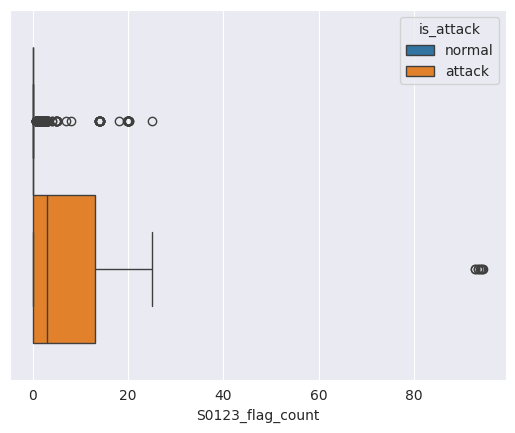

In [29]:
sns.boxplot(data=srverdf,x='S0123_flag_count',hue='is_attack')

In [30]:
pd.DataFrame(srverdf['S0123_flag_count'].describe()).T

,count,mean,std,min,25%,50%,75%,max
S0123_flag_count,125973.0,3.049338,6.06351,0.0,0.0,0.0,2.0,94.54


In [31]:
# divide data ino bins based on number of active flags for the host: again first and last 25% have most attacks
srverdf['cbins'] = None
for i in range(len(srverdf)):
  ser = srverdf.loc[i,'S0123_flag_count']
  if ser < 25:
    srverdf.loc[i,'cbins'] = 1
  elif ser >= 25 and ser < 50:
    srverdf.loc[i,'cbins'] = 2
  elif ser >= 50 and ser < 75:
    srverdf.loc[i,'cbins'] = 3
  else:
    srverdf.loc[i,'cbins'] = 4

In [32]:
srverdf['cbins'].value_counts()

,count
cbins,
1,125459
2,506
4,8


In [33]:
# no values under bin3; bin 2 and 4 have all attacks
pd.pivot_table(data=srverdf,index='cbins',columns='is_attack',values='attk',aggfunc='count')

is_attack,attack,normal
cbins,,
1,58116.0,67343.0
2,506.0,NaN
4,8.0,NaN


In [34]:
# detailed sub binning under bin 1, find the value after which attacks rise
srverdf['cbin2'] = None
for i in range(len(srverdf)):
  ser = srverdf.loc[i,'S0123_flag_count']
  if ser < 5:
    srverdf.loc[i,'cbin2'] = 1
  elif ser >= 5 and ser < 10:
    srverdf.loc[i,'cbin2'] = 2
  elif ser >= 10 and ser < 15:
    srverdf.loc[i,'cbin2'] = 3
  elif ser >= 15 and ser < 20:
    srverdf.loc[i,'cbin2'] = 4
  else:
    srverdf.loc[i,'cbin2'] = 5

In [35]:
srverdf['cbin2'].value_counts()

,count
cbin2,
1,99187
4,7825
2,7823
3,7019
5,4119


In [36]:
# After bin1, after 5 requests in last 2 seconds on same service on same host, attack chances increase
pd.pivot_table(data=srverdf,index='cbin2',columns='is_attack',values='attk',aggfunc='count')

is_attack,attack,normal
cbin2,,
1,31889,67298
2,7817,6
3,7007,12
4,7807,18
5,4110,9


In [37]:
# services with most requests in the dataset across different hosts
srverdf.groupby('service')['S0123_flag_count'].sum().sort_values(ascending=False).head(10)

,S0123_flag_count
service,
private,137070.25
http,14821.75
telnet,13319.00
ftp_data,12417.61
finger,11831.10
Z39_50,7531.00
iso_tsap,6713.00
uucp,6601.00
uucp_path,6407.00


In [38]:
# service ber number of requests bin: bin 1
pd.pivot_table(data=srverdf,index='service',columns='cbins',values='S0123_flag_count',aggfunc='count').sort_values(1,ascending=False)

cbins,1,2,4
service,,,
http,40331.0,7.0,NaN
private,21691.0,162.0,NaN
domain_u,9043.0,NaN,NaN
smtp,7312.0,1.0,NaN
ftp_data,6852.0,8.0,NaN
...,...,...,...
tftp_u,3.0,NaN,NaN
http_8001,2.0,NaN,NaN
harvest,2.0,NaN,NaN


In [39]:
# service ber number of requests bin: bin 2
pd.pivot_table(data=srverdf,index='service',columns='cbins',values='S0123_flag_count',aggfunc='count').sort_values(2,ascending=False).head(20)

cbins,1,2,4
service,,,
private,21691.0,162.0,NaN
Z39_50,853.0,9.0,NaN
finger,1758.0,9.0,NaN
link,466.0,9.0,NaN
netbios_ssn,353.0,9.0,NaN
nntp,287.0,9.0,NaN
sunrpc,372.0,9.0,NaN
uucp_path,680.0,9.0,NaN
vmnet,608.0,9.0,NaN


In [40]:
# service ber number of requests bin: bin 4
pd.pivot_table(data=srverdf,index='service',columns='cbins',values='S0123_flag_count',aggfunc='count').sort_values(4,ascending=False).head(2)

cbins,1,2,4
service,,,
imap4,632.0,7.0,8.0
IRC,187.0,NaN,NaN


In [45]:
# attacks ber number of requests bin: bin 1
pd.pivot_table(data=srverdf,index='attack',columns='cbins',values='S0123_flag_count',aggfunc='count').sort_values(1,ascending=False).head(10)

cbins,1,2,4
attack,,,
normal,67343.0,NaN,NaN
neptune,40708.0,506.0,NaN
satan,3633.0,NaN,NaN
ipsweep,3599.0,NaN,NaN
portsweep,2931.0,NaN,NaN
smurf,2646.0,NaN,NaN
nmap,1493.0,NaN,NaN
back,956.0,NaN,NaN
teardrop,892.0,NaN,NaN


In [47]:
# attacks ber number of requests bin: bin 2
pd.pivot_table(data=srverdf,index='attack',columns='cbins',values='S0123_flag_count',aggfunc='count').sort_values(2,ascending=False).head(2)

cbins,1,2,4
attack,,,
neptune,40708.0,506.0,NaN
back,956.0,NaN,NaN


In [49]:
# attacks ber number of requests bin: bin 4
pd.pivot_table(data=srverdf,index='attack',columns='cbins',values='S0123_flag_count',aggfunc='count').sort_values(4,ascending=False).head(2)

cbins,1,2,4
attack,,,
imap,3.0,NaN,8.0
back,956.0,NaN,NaN


In [51]:
df['rerrorrate'].value_counts()

,count
rerrorrate,
0.00,109783
1.00,12874
0.90,269
0.92,216
0.93,210
...,...
0.65,1
0.63,1
0.18,1


In [52]:
df['rerrorrate'].nunique()

82

<Axes: xlabel='rerrorrate', ylabel='Density'>

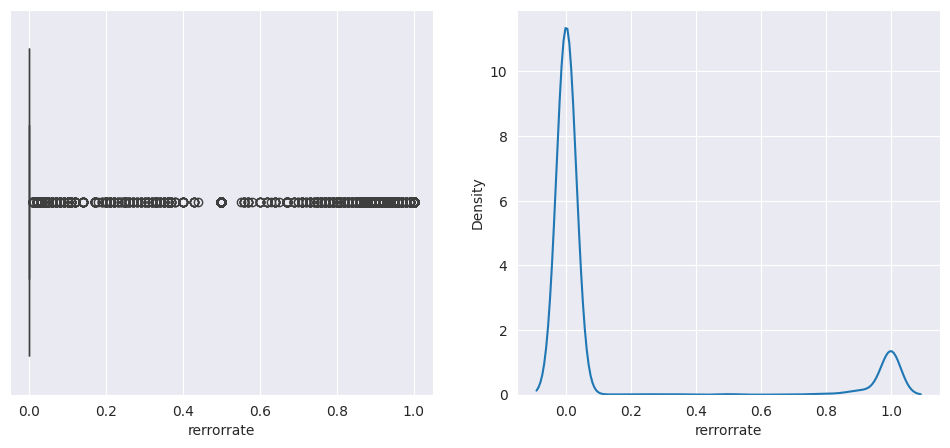

In [53]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='rerrorrate')
plt.subplot(1,2,2)
sns.kdeplot(data=df,x='rerrorrate')

In [54]:
pd.DataFrame(df['rerrorrate'].describe()).T

,count,mean,std,min,25%,50%,75%,max
rerrorrate,125973.0,0.119958,0.320436,0.0,0.0,0.0,0.0,1.0


In [55]:
np.percentile(df['rerrorrate'],75),np.percentile(df['rerrorrate'],50),np.percentile(df['rerrorrate'],25)

(0.0, 0.0, 0.0)

In [58]:
IQR = np.percentile(df['rerrorrate'],75)-np.percentile(df['rerrorrate'],25)
ulimit = np.percentile(df['rerrorrate'],75) + 1.5*IQR
ulimit

0.0

In [59]:
not_outlier = df[df['rerrorrate'] <= ulimit]
is_outlier = df[df['rerrorrate'] > ulimit]
total_data = df.shape[0]
(not_outlier.shape[0]/total_data)*100, (is_outlier.shape[0]/total_data)*100

(87.14803965929208, 12.85196034070793)

In [60]:
not_outlier['is_attack'].value_counts()

,count
is_attack,
normal,64146
attack,45637


In [61]:
is_outlier['is_attack'].value_counts()

,count
is_attack,
attack,12993
normal,3197


In [62]:
# attacks when greater than 50%
df[df['rerrorrate']>=0.5]['is_attack'].value_counts()

,count
is_attack,
attack,12309
normal,3028


In [63]:
# attacks when less than 50%
df[df['rerrorrate']<0.5]['is_attack'].value_counts()

,count
is_attack,
normal,64315
attack,46321


In [64]:
rerdf = df.copy()
rerdf['login_failed'] = rerdf['numfailedlogins'].apply(lambda x: 0 if x == 0 else 1)
rerdf['is_hot'] = rerdf['hot'].apply(lambda x: 1 if x > 0 else 0)
rerdf['is_compromised'] = rerdf['numcompromised'].apply(lambda x: 1 if x > 0 else 0)
rerdf['nroot'] = rerdf['numroot'].apply(lambda x: 1 if x > 0 else 0)
rerdf['fc'] = rerdf['numfilecreations'].apply(lambda x: 1 if x > 0 else 0)
rerdf['attk'] = rerdf['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [65]:
# bin the data into 4 groups
rerdf['bins'] = None
for i in range(len(rerdf)):
  ser = rerdf.loc[i,'rerrorrate']
  if ser < 0.25:
    rerdf.loc[i,'bins'] = 1
  elif ser >= 0.25 and ser < 0.5:
    rerdf.loc[i,'bins'] = 2
  elif ser >= 0.5 and ser < 0.75:
    rerdf.loc[i,'bins'] = 3
  else:
    rerdf.loc[i,'bins'] = 4

In [66]:
rerdf['bins'].value_counts()

,count
bins,
1,110369
4,15067
3,270
2,267


In [67]:
# number of attacks across each bin
pd.pivot_table(data=rerdf,index='bins',columns='is_attack',values='attk',aggfunc='count')

is_attack,attack,normal
bins,,
1,46106,64263
2,215,52
3,124,146
4,12185,2882


In [69]:
# type of attack in each bin : bin 1
pd.pivot_table(data=rerdf[rerdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
neptune,34308.0,12.0,6.0,6888.0
ipsweep,3172.0,NaN,1.0,426.0
smurf,2646.0,NaN,NaN,NaN
satan,1494.0,21.0,31.0,2087.0
nmap,1493.0,NaN,NaN,NaN
teardrop,892.0,NaN,NaN,NaN
warezclient,887.0,NaN,1.0,2.0
back,801.0,96.0,45.0,14.0
pod,201.0,NaN,NaN,NaN


In [71]:
# type of attack in each bin : bin 2
pd.pivot_table(data=rerdf[rerdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(2,ascending=False).head()

bins,1,2,3,4
attack,,,,
back,801.0,96.0,45.0,14.0
portsweep,89.0,86.0,36.0,2720.0
satan,1494.0,21.0,31.0,2087.0
neptune,34308.0,12.0,6.0,6888.0
buffer_overflow,29.0,NaN,1.0,NaN


In [75]:
# type of attack in each bin : bin 3
pd.pivot_table(data=rerdf[rerdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(3,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
back,801.0,96.0,45.0,14.0
portsweep,89.0,86.0,36.0,2720.0
satan,1494.0,21.0,31.0,2087.0
neptune,34308.0,12.0,6.0,6888.0
guess_passwd,3.0,NaN,2.0,48.0
buffer_overflow,29.0,NaN,1.0,NaN
ipsweep,3172.0,NaN,1.0,426.0
land,17.0,NaN,1.0,NaN
warezclient,887.0,NaN,1.0,2.0


In [76]:
# type of attack in each bin : bin 4
pd.pivot_table(data=rerdf[rerdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(4,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
neptune,34308.0,12.0,6.0,6888.0
portsweep,89.0,86.0,36.0,2720.0
satan,1494.0,21.0,31.0,2087.0
ipsweep,3172.0,NaN,1.0,426.0
guess_passwd,3.0,NaN,2.0,48.0
back,801.0,96.0,45.0,14.0
warezclient,887.0,NaN,1.0,2.0
buffer_overflow,29.0,NaN,1.0,NaN
ftp_write,8.0,NaN,NaN,NaN


In [78]:
# detailed sub binning under bin 1, find the value after which attacks rise
rerdf['cbin2'] = None
for i in range(len(rerdf)):
  ser = rerdf.loc[i,'rerrorrate']
  if ser < 0.05:
    rerdf.loc[i,'cbin2'] = 1
  elif ser >= 0.05 and ser < 0.1:
    rerdf.loc[i,'cbin2'] = 2
  elif ser >= 0.1 and ser < 0.15:
    rerdf.loc[i,'cbin2'] = 3
  elif ser >= 0.15 and ser < 0.20:
    rerdf.loc[i,'cbin2'] = 4
  elif ser >= 0.20 and ser < 0.25:
    rerdf.loc[i,'cbin2'] = 5
  else:
    rerdf.loc[i,'cbin2'] = 6

In [79]:
# number of attacks across each sub bin
pd.pivot_table(data=rerdf,index='cbin2',columns='is_attack',values='attk',aggfunc='count')

is_attack,attack,normal
cbin2,,
1,45907,64168
2,79,39
3,21,30
4,26,11
5,73,15
6,12524,3080


In [83]:
# type of attacks across each sub bin
pd.pivot_table(data=rerdf,index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

cbin2,1,2,3,4,5,6
attack,,,,,,
normal,64168.0,39.0,30.0,11.0,15.0,3080.0
neptune,34206.0,74.0,16.0,6.0,6.0,6906.0
ipsweep,3172.0,NaN,NaN,NaN,NaN,427.0
smurf,2646.0,NaN,NaN,NaN,NaN,NaN
satan,1493.0,NaN,NaN,1.0,NaN,2139.0
nmap,1493.0,NaN,NaN,NaN,NaN,NaN
teardrop,890.0,2.0,NaN,NaN,NaN,NaN
warezclient,887.0,NaN,NaN,NaN,NaN,3.0
back,742.0,2.0,5.0,16.0,36.0,155.0


In [85]:
# type of attacks across each sub bin
pd.pivot_table(data=rerdf,index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(2,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
neptune,34206.0,74.0,16.0,6.0,6.0,6906.0
normal,64168.0,39.0,30.0,11.0,15.0,3080.0
back,742.0,2.0,5.0,16.0,36.0,155.0
teardrop,890.0,2.0,NaN,NaN,NaN,NaN
portsweep,54.0,1.0,NaN,3.0,31.0,2842.0


In [86]:
# type of attacks across each sub bin
pd.pivot_table(data=rerdf,index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(3,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
normal,64168.0,39.0,30.0,11.0,15.0,3080.0
neptune,34206.0,74.0,16.0,6.0,6.0,6906.0
back,742.0,2.0,5.0,16.0,36.0,155.0
buffer_overflow,29.0,NaN,NaN,NaN,NaN,1.0
ftp_write,8.0,NaN,NaN,NaN,NaN,NaN


In [87]:
# type of attacks across each sub bin
pd.pivot_table(data=rerdf,index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(4,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
back,742.0,2.0,5.0,16.0,36.0,155.0
normal,64168.0,39.0,30.0,11.0,15.0,3080.0
neptune,34206.0,74.0,16.0,6.0,6.0,6906.0
portsweep,54.0,1.0,NaN,3.0,31.0,2842.0
satan,1493.0,NaN,NaN,1.0,NaN,2139.0


In [88]:
df['srvrerrorrate'].value_counts()

,count
srvrerrorrate,
0.00,109767
1.00,14827
0.50,244
0.33,160
0.25,114
...,...
0.90,1
0.55,1
0.18,1


In [89]:
df['srvrerrorrate'].nunique()

62